# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
state = RandomState(12345)

In [2]:
# Объявим переменные, 
PROFIT = 450_000 # Доход с единицы продукта - то есть с тысячи бареллей (450 тыс рублей)
BUDGET = 10_000_000_000 # Бюджет на разработку скважин в одном регионе (10 млрд рублей)
ONE_REGION = 500 # Количество скважин в одном регионе для исследования
ONE_REGION_BEST = 200 # Количество лучших скважин для разработки в одном регионе (well - скважина)
ONE_WELL = BUDGET / ONE_REGION_BEST

In [3]:
# Загрузим данные с 3-х регионов
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
df_0.info()
df_0.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.info()
df_1.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
df_2.info()
df_2.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
# Разделим данные на признаки и целевой признак. Удалим ненужный столбец id.
features_0 = df_0.drop(['product', 'id'], axis=1)
features_1 = df_1.drop(['product', 'id'], axis=1)
features_2 = df_2.drop(['product', 'id'], axis=1)
target_0 = df_0['product']
target_1 = df_1['product']
target_2 = df_2['product']

In [8]:
# Удалим дупликаты в 'id' 
df_0['id'] = df_0['id'].drop_duplicates()
df_1['id'] = df_1['id'].drop_duplicates()
df_2['id'] = df_2['id'].drop_duplicates()

array([[<AxesSubplot:title={'center':'product'}>]], dtype=object)

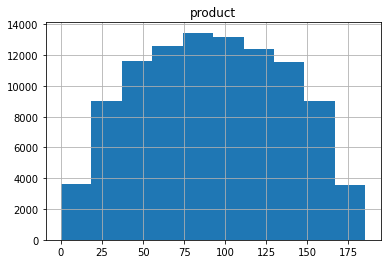

In [9]:
df_0.hist(column='product')

array([[<AxesSubplot:title={'center':'product'}>]], dtype=object)

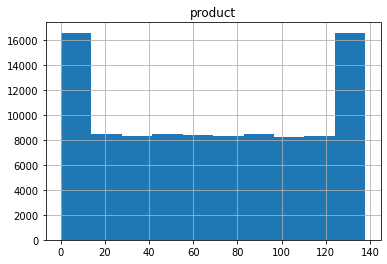

In [10]:
df_1.hist(column='product')

array([[<AxesSubplot:title={'center':'product'}>]], dtype=object)

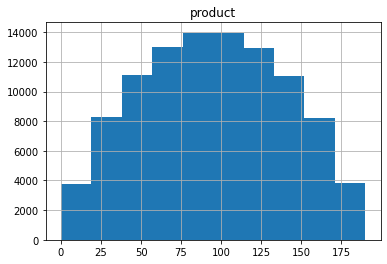

In [11]:
df_2.hist(column='product')

In [12]:
# Посмотрим на корреляцию признаков в 3-х датасетах
df_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [13]:
df_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [14]:
df_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Вывод:
- Загрузили данные по трем регионам. Изучили датасеты с помощью функции info();
- Ни один из трех датасетов не содержит пропусков;
- Разделили признаки и целевой признак;
- Удалили дупликаты по столбцу 'id';
- Построили гистограммы распределения для целевого признака каждого датасета;
- Удалили столбец 'id' за ненадобностью при обучении модели;
- Проверили корреляцию признаков на всех датасетах. Никаких зависимостей между признаками обнаружено не было.

## Обучение и проверка модели

In [15]:
# Разделили выборки на обучающую и валидационную для каждого региона
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=12345)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=12345)

In [16]:
# Обучили модели для каждого региона
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predicted_0 = model_0.predict(features_valid_0)

model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predicted_1 = model_1.predict(features_valid_1)

model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predicted_2 = model_2.predict(features_valid_2)

In [17]:
round(predicted_0.mean(), 2)

92.59

In [18]:
rmse_0 = math.sqrt(mean_squared_error(target_valid_0, predicted_0))
round(rmse_0, 2)

37.58

In [19]:
round(predicted_1.mean(), 2)

68.73

In [20]:
rmse_1 = math.sqrt(mean_squared_error(target_valid_1, predicted_1))
round(rmse_1, 2)

0.89

In [21]:
round(predicted_2.mean(), 2)

94.97

In [22]:
rmse_2 = math.sqrt(mean_squared_error(target_valid_2, predicted_2))
round(rmse_2, 2)

40.03

Вывод:
- Рассчитали средний запас предсказанного сырья в каждом регионе и RMSE для каждой модели;
- Для региона 0 средний запас равен 92.59 единиц продукта, RMSE модели равен 37.58. Такие же показатели для регионов 1 и 2 равны 68.73 и 0.89, 94.97 и 40.03 соответственно.
- Для регионов 0 и 2 размер ошибки довольно велик - 40% и 42% от предсказанного запаса соответственно.

## Подготовка к расчёту прибыли

In [23]:
# Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины
C = ONE_WELL / PROFIT
round(C, 2)

111.11

Вывод:
- Для всех ключевых значений были созданы константы в Python;
- Рассчитали достаточный объем сырья для безубыточной разработки новой скважины. Это величина равна 111.11 единиц продукта (тысяч баррелей).
- Сравнили данную величину со средним запасом в каждом регионе. Для региона 0 средний запас равняется 92.59 единиц продукта, для региона 1 - 68.73 единицы продукта, для региона 2 - 94.97 единицы продукта.

## Расчёт прибыли и рисков 

In [24]:
# Функция для расчета прибыли 
def revenue(target, predictions, profit, budget):
    sorted_predictions = predictions.sort_values(ascending=False)
    sorted_target = target[sorted_predictions.index]
    best_200 = sorted_target[:ONE_REGION_BEST]
    result = (best_200.sum()) * profit - budget
    return result

In [33]:
# Бутстреп. Регион 0.
pr_0 = []
d_0 = 0 # Счетчик регионов с отрицательной прибылью
for j in range(1000):
    subsample = target_valid_0.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
    predicted_500_0 = pd.Series(predicted_0).reset_index(drop=True)[subsample.index]
    revenue_0 = revenue(subsample, predicted_500_0, PROFIT, BUDGET)
    if revenue_0 < 0:
        d_0 += 1
    else:
        d_0 += 0
    pr_0.append(revenue_0)

    
pr_0 = pd.Series(pr_0)
lower_0 = round(pr_0.quantile(0.025), 2)
upper_0 = round(pr_0.quantile(0.975), 2)
print(f"95-процентный доверительный интервал: ({lower_0}, {upper_0})")
print("Средняя прибыль:", round(pr_0.mean(), 2))
print("Риск убытков:", d_0 / 10, "%")
    
    
    

95-процентный доверительный интервал: (-124880785.5, 945764266.29)
Средняя прибыль: 404540995.49
Риск убытков: 6.4 %


In [26]:
# ячейка ревьюера
target_valid_1.head()              

71751    80.859783
80493    53.906522
2655     30.132364
53233    53.906522
91141     0.000000
Name: product, dtype: float64

In [28]:
# Бутстреп. Регион 1.
pr_1 = []
d_1 = 0 # Счетчик регионов с отрицательной прибылью
for l in range(1000):
    subsample_1 = pd.Series(target_valid_1).reset_index(drop=True).sample(n=500, replace=True, random_state=state)
    predicted_500_1 = pd.Series(predicted_1).reset_index(drop=True)[subsample_1.index]
    revenue_1 = revenue(subsample_1, predicted_500_1, PROFIT, BUDGET)
    if revenue_1 < 0:
        d_1 += 1
    else:
        d_1 += 0
    pr_1.append(revenue_1)

    
pr_1 = pd.Series(pr_1)
lower_1 = round(pr_1.quantile(0.025), 2)
upper_1 = round(pr_1.quantile(0.975), 2)
print(f"95-процентный доверительный интервал: ({lower_1}, {upper_1})")
print("Средняя прибыль:", round(pr_1.mean(), 2))
print("Риск убытков:", d_1 / 10, "%")
    

95-процентный доверительный интервал: (128123231.43, 953612982.07)
Средняя прибыль: 518259493.7
Риск убытков: 0.3 %


In [29]:
# Бутстреп. Регион 2.
pr_2 = []
d_2 = 0 # Счетчик регионов с отрицательной прибылью
for h in range(1000):
    subsample_2 = pd.Series(target_valid_2).reset_index(drop=True).sample(n=500, replace=True, random_state=state)
    predicted_500_2 = pd.Series(predicted_2).reset_index(drop=True)[subsample_2.index]
    revenue_2 = revenue(subsample_2, predicted_500_2, PROFIT, BUDGET)
    if revenue_2 < 0:
        d_2 += 1
    else:
        d_2 += 0
    pr_2.append(revenue_2)

    
pr_2 = pd.Series(pr_2)
lower_2 = round(pr_2.quantile(0.025), 2)
upper_2 = round(pr_2.quantile(0.975), 2)
print(f"95-процентный доверительный интервал: ({lower_2}, {upper_2})")
print("Средняя прибыль:", round(pr_2.mean(), 2))
print("Риск убытков:", d_2 / 10, "%")
    
    
    

95-процентный доверительный интервал: (-115852609.16, 989629939.84)
Средняя прибыль: 420194005.34
Риск убытков: 6.2 %


# **Вывод**:
Самый прибыльный регион - это регион 1. Он подходит по 2-м критериям:
1) Риск убытков там - 0.3%, что меньше 2.5%, данных в ТЗ.
2) Самая большая средняя прибыль среди всех регионов: 518259493.7 рублей.